<h1 style="text-align: center; font-size: 50px;"> Handwritten digit classification with keras MLflow integration </h1>

Notebook Overview
- Start Execution
- User Constants 
- Install and Import Libraries
- Configure Settings
- Logging Model to MLflow
- Fetching the Latest Model Version from MLflow
- Loading the Model and Running Inference


## Start Execution

In [1]:
%pip install -r ../requirements.txt --quiet

Note: you may need to restart the kernel to use updated packages.


In [2]:
import logging
import time

# Configure logger
logger: logging.Logger = logging.getLogger("register_model_logger")
logger.setLevel(logging.INFO)
logger.propagate = False  # Prevent duplicate logs from parent loggers

# Set formatter
formatter: logging.Formatter = logging.Formatter(
    fmt="%(asctime)s - %(levelname)s - %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S"
)

# Configure and attach stream handler
stream_handler: logging.StreamHandler = logging.StreamHandler()
stream_handler.setFormatter(formatter)
logger.addHandler(stream_handler)

In [ ]:
start_time = time.time()  

logger.info("Notebook execution started.")

2025-07-30 23:14:42 - INFO - Notebook execution started.


## User Constants

In [4]:
DIGIT_BASE64 = "/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/wAALCAAcABwBAREA/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/9oACAEBAAA/APn+prW0uL66itbSCSe4lbbHFEpZmPoAOtaWt+FtZ8Ox28mqWghS4LCNlmSQblxuU7GO1huGQcHnpWPRXoOiWF/pfhiwh0K2ln8R+JfMWNoh89vaK2w7f7pdg2Wzwq9sk1X+IY03SItJ8JabMLk6QsjX1wpOJLuQr5gHsuxQP/rVw1Fen+EfFmueF/AN3qkup3C2yMbPR7QkBXmbJkk9SsYOcfd3MK8yd3lkaSRizsSzMxyST1JptFXLnVb280+ysJ5y9rYhxbx4AEe9tzdBzk9z7elU6K//2Q=="

## Install and Import Libraries

In [5]:
from PIL import Image
import base64
from io import BytesIO
import warnings                         
import logging  
import sys
import os

import numpy as np
import pandas as pd  

import matplotlib.pyplot as plt


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist

# ------------------------ MLflow Integration ------------------------
import mlflow
from mlflow import MlflowClient
from mlflow.models.signature import ModelSignature
from mlflow.types.schema import Schema, ColSpec


# ------------------------ Utils Import ------------------------
sys.path.append("../src")
from onnx_utils import ModelExportConfig
from utils import load_config


2025-07-30 23:14:44.854399: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-30 23:14:44.898210: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753917284.940406    5008 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753917284.959325    5008 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-30 23:14:45.012698: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## Configure Settings

In [6]:
# ------------------------- MLflow Experiment Configuration -------------------------
EXPERIMENT_NAME = 'MNIST with TensorFlow'
RUN_NAME = "MNIST_Run"
MODEL_NAME = "MNIST_Model"
MODEL_PATH = "model_keras_mnist.keras"

In [7]:
# Suppress Python warnings
warnings.filterwarnings("ignore")

In [ ]:
# Configuration paths
CONFIG_PATH = "../configs/config.yaml" 
DEMO_FOLDER = "../demo"

# Load configuration
config = load_config(CONFIG_PATH)

logger.info("✅ Configuration loaded successfully")

2025-07-30 23:14:56 - INFO - ✅ Configuration loaded successfully


## Logging Model to MLflow

In [9]:
class MNISTModel(mlflow.pyfunc.PythonModel):
    def load_context(self, context):
        """
        Load model and configuration from artifacts.
        """
        try:
            import tensorflow as tf
            import yaml
            
            # Load the model from artifacts
            self.model = tf.keras.models.load_model(context.artifacts["mnist_model"])
            
            # Load configuration from artifacts (like vanilla-rag does)
            config_path = context.artifacts["config"]
            with open(config_path, 'r') as f:
                self.config = yaml.safe_load(f)
            
            logger.info("✅ Model and configuration loaded successfully")

        except Exception as e:
            logger.error(f"❌ Error loading context: {str(e)}")
            raise

    def predict(self, context, model_input, params=None):
        """
        Computes the predicted digit, by converting the base64 to a numpy array.
        """
        try:
            if isinstance(model_input, pd.DataFrame):
                image_input = model_input.iloc[0, 0]
            elif isinstance(model_input, list):
                image_input = model_input[0]
            else:
                image_input = str(model_input)
                
            base64_array = base64_to_numpy(image_input)

            predictions = self.model.predict(base64_array)
            predicted_classes = np.argmax(predictions, axis=1)
            
            return predicted_classes.tolist()
        
        except Exception as e:
            logger.error(f"❌ Error performing prediction: {str(e)}")
            raise
    
    @classmethod
    def log_model(cls,artifact_path, config_path, demo_folder):
        """
        Logs the model to MLflow with appropriate artifacts and schema (vanilla-rag pattern).
        """
        
        try:
            sys.path.append("../src")
            from onnx_utils import ModelExportConfig,log_model
            
            # Define input and output schema
            input_schema = Schema([
                ColSpec("string", name="digit"),
            ])
            output_schema = Schema([
                ColSpec("long", name="prediction"),
            ])
            
            # Define model signature
            signature = ModelSignature(inputs=input_schema, outputs=output_schema)
            
            # Save the model
            model.save(MODEL_PATH)
          
            artifacts = {
                "mnist_model": MODEL_PATH,
                "config": config_path
            }
            
            if demo_folder and os.path.exists(demo_folder):
                artifacts["demo"] = demo_folder
                logger.info(f"✅ Demo folder added to artifacts: {demo_folder}")

            model_configs= [
                ModelExportConfig(
                       model_path=MODEL_PATH,
                       model_name="keras_converted",
                       input_shape=(None, 28, 28, 1),
                )    
            ]

            log_model(
                    artifact_path=artifact_path,
                    python_model=cls(),
                    artifacts=artifacts,
                    signature=signature,
                    models_to_convert_onnx=model_configs,
                    pip_requirements=[
                    "tensorflow>=2.0.0",
                    "numpy",
                    "pillow",
                    "streamlit>=1.28.0",
                    "pyyaml"
                    ]
                )
            
            logger.info("✅ Model and artifacts successfully registered in MLflow")

        except Exception as e:
            logger.error(f"❌ Error logging model: {str(e)}")
            raise

/opt/conda/lib/python3.12/site-packages/mlflow/pyfunc/utils/data_validation.py:168: UserWarning: Add type hints to the `predict` method to enable data validation and automatic signature inference during model logging. Check https://mlflow.org/docs/latest/model/python_model.html#type-hint-usage-in-pythonmodel for more details.
  color_warning(


In [10]:
# Load and preprocess MNIST data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 28, 28, 1).astype("float32") / 255.0
x_test = x_test.reshape(-1, 28, 28, 1).astype("float32") / 255.0
y_cat_train = to_categorical(y_train, 10)
y_cat_test = to_categorical(y_test, 10)

# Build a simple CNN model
model = Sequential([
    Conv2D(32, kernel_size=(4, 4), activation='relu', input_shape=(28, 28, 1)),
    MaxPool2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_cat_train, epochs=4, validation_data=(x_test, y_cat_test))

I0000 00:00:1753917298.086265    5008 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1768 MB memory:  -> device: 0, name: NVIDIA RTX A500 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Epoch 1/4


I0000 00:00:1753917303.641084    5078 service.cc:148] XLA service 0x7358d0004d30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753917303.641406    5078 service.cc:156]   StreamExecutor device (0): NVIDIA RTX A500 Laptop GPU, Compute Capability 8.6
2025-07-30 23:15:03.781647: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1753917304.284137    5078 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-07-30 23:15:05.670308: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_200', 4 bytes spill stores, 4 bytes spill loads



   2/1875 ━━━━━━━━━━━━━━━━━━━━ 2:05 67ms/step - accuracy: 0.0703 - loss: 2.3017      

I0000 00:00:1753917314.104221    5078 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 72s 31ms/step - accuracy: 0.9163 - loss: 0.2746 - val_accuracy: 0.9791 - val_loss: 0.0640
Epoch 2/4
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 48s 25ms/step - accuracy: 0.9844 - loss: 0.0481 - val_accuracy: 0.9811 - val_loss: 0.0564
Epoch 3/4
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 52s 28ms/step - accuracy: 0.9907 - loss: 0.0301 - val_accuracy: 0.9884 - val_loss: 0.0348
Epoch 4/4
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 46s 24ms/step - accuracy: 0.9942 - loss: 0.0186 - val_accuracy: 0.9887 - val_loss: 0.0361


In [11]:
def base64_to_numpy(base64_string):
    """
    Convert base64 string to numpy array for MNIST digit prediction.
    """
    try:
        # Decode the base64 string
        image_data = base64.b64decode(base64_string)
        
        # Open the image using PIL
        image = Image.open(BytesIO(image_data))
        
        # Convert to grayscale if not already
        if image.mode != 'L':
            image = image.convert('L')
        
        # Resize to 28x28 if needed
        if image.size != (28, 28):
            image = image.resize((28, 28))
        
        # Convert to numpy array
        numpy_array = np.array(image)
        
        # Normalize pixel values to 0-1 range
        numpy_array = numpy_array.astype('float32') / 255.0
        
        # Reshape for model input (1, 28, 28, 1)
        numpy_array = numpy_array.reshape(1, 28, 28, 1)
        
        return numpy_array
        
    except Exception as e:
        logger.error(f"Error converting base64 to numpy: {str(e)}")
        raise

In [12]:
logger.info(f'🚀 Starting the experiment: {EXPERIMENT_NAME}')

mlflow.set_tracking_uri('/phoenix/mlflow')
# Set the MLflow experiment name
mlflow.set_experiment(experiment_name=EXPERIMENT_NAME)

# Start an MLflow run
with mlflow.start_run(run_name=RUN_NAME) as run:
    # Print the artifact URI for reference
    logger.info(f"📁 Run's Artifact URI: {run.info.artifact_uri}")
    
    # Evaluate model
    test_loss, test_accuracy = model.evaluate(x_test, y_cat_test, verbose=0)
    mlflow.log_metrics({"test_accuracy": test_accuracy})
    mlflow.log_metrics({"test_loss": test_loss})
    
    logger.info(f"📊 Test accuracy: {test_accuracy:.4f}")

    # Log the model to MLflow using vanilla-rag pattern
    MNISTModel.log_model(
        artifact_path=MODEL_NAME,
        config_path=CONFIG_PATH,
        demo_folder=DEMO_FOLDER
    )

    # Register the logged model in MLflow Model Registry
    model_uri = f"runs:/{run.info.run_id}/{MODEL_NAME}"
    mlflow.register_model(
        model_uri=model_uri,
        name=MODEL_NAME
    )
    
    logger.info(f"✅ Model registered successfully with run ID: {run.info.run_id}")

2025-07-30 23:18:37 - INFO - 🚀 Starting the experiment: MNIST with TensorFlow
2025-07-30 23:18:40 - INFO - 📁 Run's Artifact URI: /phoenix/mlflow/999571145261950321/e179bd65bd764cf4bbdcbabd56e1c24c/artifacts
2025-07-30 23:18:47 - INFO - 📊 Test accuracy: 0.9887
2025-07-30 23:18:47 - INFO - ✅ Demo folder added to artifacts: ../demo


Converting model with input shape: (None, 28, 28, 1)
Attempting direct conversion from Keras model...


I0000 00:00:1753917530.428167    5008 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
I0000 00:00:1753917530.429837    5008 single_machine.cc:361] Starting new session
I0000 00:00:1753917530.440837    5008 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1768 MB memory:  -> device: 0, name: NVIDIA RTX A500 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1753917531.014947    5008 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1768 MB memory:  -> device: 0, name: NVIDIA RTX A500 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1753917531.318392    5008 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
I0000 00:00:1753917531.322444    5008 single_machine.cc:361] Starting new session
I0000 00:00:1753917531.328303    5008 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/devic

✅ Direct conversion successful!
Model saved to ONNX: keras_converted.onnx
✅ ONNX model saved to: keras_converted.onnx


2025/07/30 23:18:55 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - streamlit (current: uninstalled, required: streamlit>=1.28.0)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2025-07-30 23:18:58 - INFO - ✅ Model and artifacts successfully registered in MLflow
Registered model 'MNIST_Model' already exists. Creating a new version of this model...
Created version '8' of model 'MNIST_Model'.
2025-07-30 23:19:01 - INFO - ✅ Model registered successfully with run ID: e179bd65bd764cf4bbdcbabd56e1c24c


## Fetching the Latest Model Version from MLflow

In [13]:
# Initialize the MLflow client
client = MlflowClient()

# Retrieve the latest version of the model
model_metadata = client.get_latest_versions(MODEL_NAME, stages=["None"])
latest_model_version = model_metadata[0].version  # Extract the latest model version

# Fetch model information, including its signature
model_info = mlflow.models.get_model_info(f"models:/{MODEL_NAME}/{latest_model_version}")

# Print the latest model version and its signature
logger.info(f"Latest Model Version: {latest_model_version}")
logger.info(f"Model Signature: {model_info.signature}")

2025-07-30 23:19:05 - INFO - Latest Model Version: 8
2025-07-30 23:19:05 - INFO - Model Signature: inputs: 
  ['digit': string (required)]
outputs: 
  ['prediction': long (required)]
params: 
  None



## Loading the Model and Running Inference

2025/07/30 23:19:05 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - streamlit (current: uninstalled, required: streamlit>=1.28.0)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2025-07-30 23:19:06 - INFO - ✅ Model and configuration loaded successfully


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step


2025-07-30 23:19:07 - INFO - Predicted class: [9]


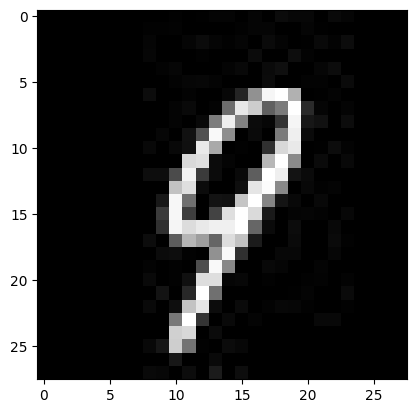

In [14]:
model = mlflow.pyfunc.load_model(model_uri=f"models:/{MODEL_NAME}/{latest_model_version}")

# Base64 example
base = DIGIT_BASE64
numpy_image = base64_to_numpy(base)
# Image of the base64 example
plt.imshow(numpy_image.squeeze(), cmap= 'gray') 

base_input = pd.DataFrame({"digit": [base]})
# Prediction of base64
predictions = model.predict(base_input)

logger.info(f"Predicted class: {predictions}")

In [15]:
end_time: float = time.time()
elapsed_time: float = end_time - start_time
elapsed_minutes: int = int(elapsed_time // 60)
elapsed_seconds: float = elapsed_time % 60

logger.info(f"⏱️ Total execution time: {elapsed_minutes}m {elapsed_seconds:.2f}s")
logger.info("✅ Notebook execution completed successfully.")

2025-07-30 23:19:07 - INFO - ⏱️ Total execution time: 4m 24.68s
2025-07-30 23:19:07 - INFO - ✅ Notebook execution completed successfully.


Built with ❤️ using [**Z by HP AI Studio**](https://zdocs.datascience.hp.com/docs/aistudio/overview).